In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [76]:
plt.style.use('ggplot')
plt.style.use('seaborn-bright')

In [77]:
bb_usage_info = pd.read_excel("data/2.1 BB Usage Information.xlsx")  
bb_usage_info

,event_source.hash,upload,download,duration,ym
0,97f49f125b5091510366b7ed202aa812,301208959,706750143,37554,202107
1,8c04b64e4e3e94a6194b084110e01043,434569120,9643579465,203150,202104
2,292d4e6f305ea01af22802f16882c817,155351309,5068672660,871979,202107
3,8c04b64e4e3e94a6194b084110e01043,175960806,3584919166,213062,202106
4,40ec397ea821e66dd93065a3b8e8307f,6549583686,380182019793,1800576,202102
...,...,...,...,...,...
546705,7c8e9c38c6cfc2bde0d9bf35f544b2cb,466080238,14254807609,680110,202103
546706,3fdae19709fc5857acc14423bab3a93e,839666411,7847458006,276493,202011
546707,67c088869be9d064e702c2ba65a0f252,210069416,2497186286,140187,202106
546708,67c088869be9d064e702c2ba65a0f252,216196814,653697953,106229,202107


In [78]:
bb_usage_info.dropna(subset = ["upload","download","duration"],inplace=True)
bb_usage_info.shape

(546710, 5)

In [79]:
bb_usage_info.rename(columns = {"ym": "year-month"}, inplace = True)

In [80]:
bb_usage_info.isnull().sum(axis=0)

event_source.hash    0
upload               0
download             0
duration             0
year-month           0
dtype: int64

In [81]:
bb_usage_info['duration'].fillna(0)
bb_usage_info['upload'].fillna(0)
bb_usage_info['download'].fillna(0)

0            706750143
1           9643579465
2           5068672660
3           3584919166
4         380182019793
              ...     
546705     14254807609
546706      7847458006
546707      2497186286
546708       653697953
546709      8615159154
Name: download, Length: 546710, dtype: int64

# Phase 1

## Usage Ranking

- 1. Pivot by year-month
- 2. Bin by Upload/Download/Duration
- 3. Usage Rank
- 4. Labling usage

In [82]:
bb_usage_info['usage'] = bb_usage_info.loc[:,['upload','download']].sum(axis=1)
bb_usage_info = bb_usage_info.drop(['upload','download'], axis=1)
bb_usage_info


,event_source.hash,duration,year-month,usage
0,97f49f125b5091510366b7ed202aa812,37554,202107,1007959102
1,8c04b64e4e3e94a6194b084110e01043,203150,202104,10078148585
2,292d4e6f305ea01af22802f16882c817,871979,202107,5224023969
3,8c04b64e4e3e94a6194b084110e01043,213062,202106,3760879972
4,40ec397ea821e66dd93065a3b8e8307f,1800576,202102,386731603479
...,...,...,...,...
546705,7c8e9c38c6cfc2bde0d9bf35f544b2cb,680110,202103,14720887847
546706,3fdae19709fc5857acc14423bab3a93e,276493,202011,8687124417
546707,67c088869be9d064e702c2ba65a0f252,140187,202106,2707255702
546708,67c088869be9d064e702c2ba65a0f252,106229,202107,869894767


### BB Usage Trend Analysis

In [83]:
bb_usage_for_plot = bb_usage_info
bb_usage_for_plot["year-month"] = bb_usage_for_plot["year-month"].astype("category")

In [84]:
bb_usage_for_plot.groupby("year-month").sum()

,duration,usage
year-month,,
202011,149978697174,3945203867761838
202012,82089511910,2015976699449969
202101,83158783908,2063905348829356
202102,80034272869,2026087217763413
202103,89461120930,2209671574072926
202104,95935636055,2912243632422726
202105,95935636055,2912243632422726
202106,101375757797,3215930128661097
202107,110288933602,3235825604256620


Text(0.5, 0.98, 'Broadband Duration (in hours) with Time')

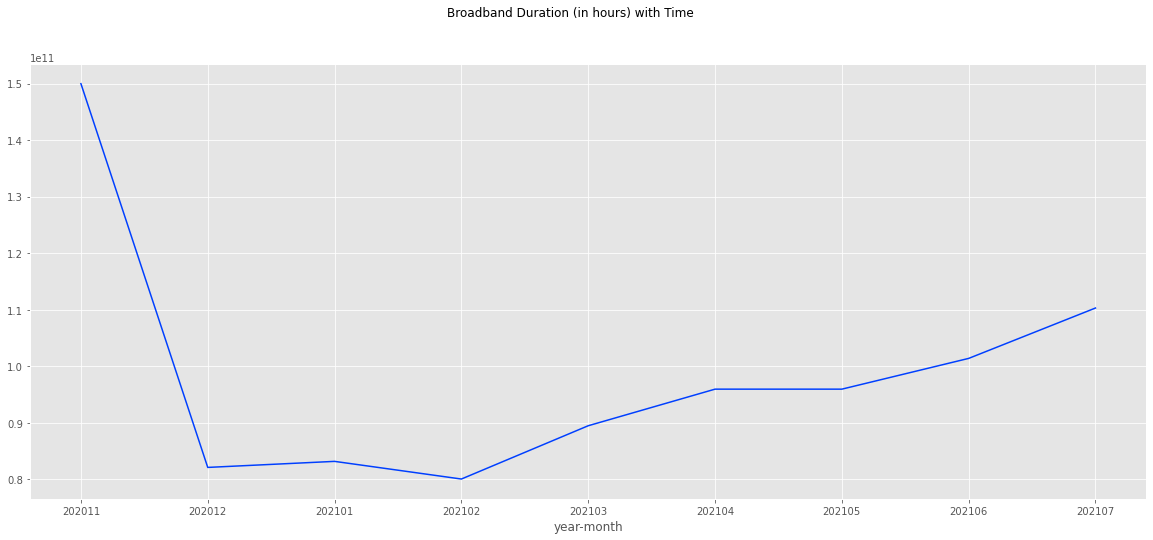

In [85]:
plt.figure(figsize=(20,8))
bb_usage_for_plot.groupby("year-month").sum()["duration"].plot()
plt.suptitle("Broadband Duration (in hours) with Time")

Text(0.5, 0.98, 'BroadBand Usage(in Bytes) with Time')

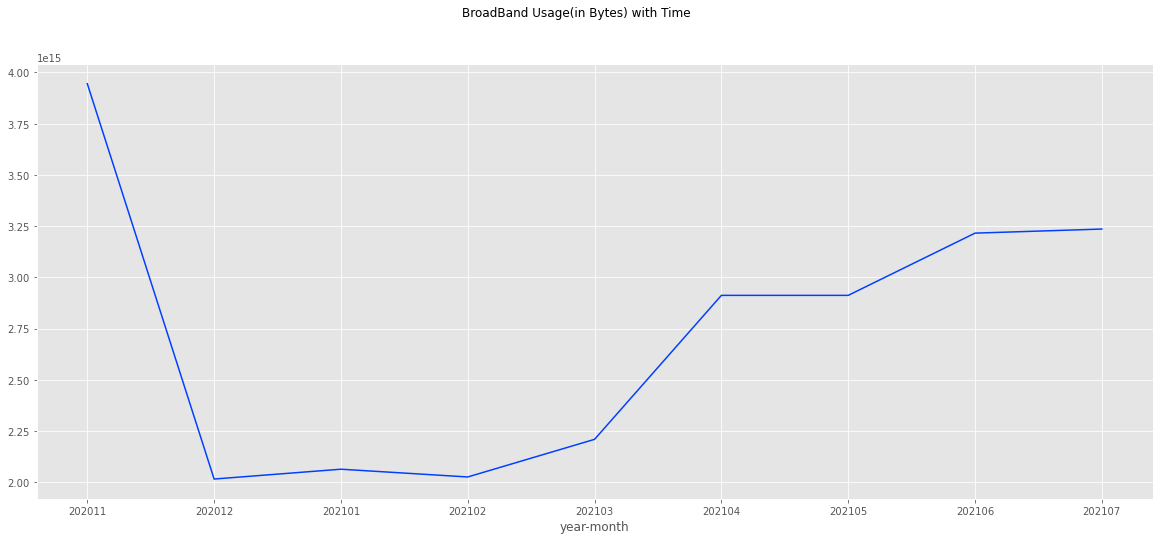

In [86]:
plt.figure(figsize=(20,8))
bb_usage_for_plot.groupby("year-month").sum()["usage"].plot()
plt.suptitle("BroadBand Usage(in Bytes) with Time")

In [87]:
bb_usage_info["usage"] = bb_usage_info["usage"].apply(lambda x: round(x/1000, 3))

In [88]:
bb_usage_info.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,duration,usage
count,546710.00000,546710.00000
mean,1624734.04602,44881358.86602
std,869854.34590,61661371.39620
min,0.00000,0.00000
25%,884806.00000,10036018.00300
50%,1733984.00000,26325708.82400
75%,2460485.00000,59722456.04475
max,13037183.00000,3108674481.06900


In [89]:
# binning usage
usage_bins = [0, 10036018.003, 26325708.824,59722456.04475, 3108674481.069]
bb_usage_info['usage'] = np.searchsorted(usage_bins, bb_usage_info['usage'].values)

In [90]:
# binning duration
duration_bins = [0, 884806.0, 1733984.0, 2460485.0,13037183.0]
bb_usage_info['duration'] = np.searchsorted(duration_bins, bb_usage_info['duration'].values)

In [91]:
bb_usage_info['rating'] = bb_usage_info['usage'] * bb_usage_info['duration']

### Justification
- https://www.researchgate.net/post/Can-I-combine-2-independent-variable-as-one-variable-in-a-model-Can-I-still-include-the-individual-variable-in-the-same-model-after-combing-the-two
- http://www.utstat.toronto.edu/~brunner/DataAnalysisText/Interactions.pdf

### More advanced methods
- Dimension reduction approaches?

### Usage ratings for year-month

In [92]:
bb_usage_info.drop(['usage','duration'], axis=1, inplace= True)
bb_usage_info

,event_source.hash,year-month,rating
0,97f49f125b5091510366b7ed202aa812,202107,1
1,8c04b64e4e3e94a6194b084110e01043,202104,2
2,292d4e6f305ea01af22802f16882c817,202107,1
3,8c04b64e4e3e94a6194b084110e01043,202106,1
4,40ec397ea821e66dd93065a3b8e8307f,202102,12
...,...,...,...
546705,7c8e9c38c6cfc2bde0d9bf35f544b2cb,202103,2
546706,3fdae19709fc5857acc14423bab3a93e,202011,1
546707,67c088869be9d064e702c2ba65a0f252,202106,1
546708,67c088869be9d064e702c2ba65a0f252,202107,1


In [93]:
# scaling usage rating
scaler = MinMaxScaler()
bb_usage_info['rating'] = scaler.fit_transform(bb_usage_info['rating'].values.reshape(-1,1))

<AxesSubplot:>

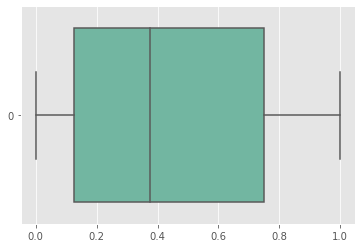

In [98]:
ax = sns.boxplot(data=bb_usage_info['rating'], orient="h", palette="Set2")
ax

<AxesSubplot:ylabel='Density'>

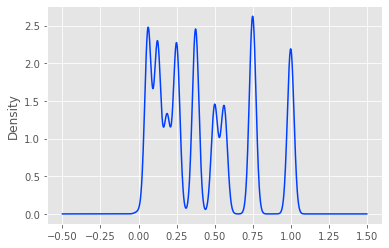

In [99]:
bb_usage_info['rating'].plot(kind = 'density')

### Fina Result: Usage Ratings for Scoring

In [102]:
bb_usage_info

,event_source.hash,year-month,rating
0,97f49f125b5091510366b7ed202aa812,202107,0.0625
1,8c04b64e4e3e94a6194b084110e01043,202104,0.1250
2,292d4e6f305ea01af22802f16882c817,202107,0.0625
3,8c04b64e4e3e94a6194b084110e01043,202106,0.0625
4,40ec397ea821e66dd93065a3b8e8307f,202102,0.7500
...,...,...,...
546705,7c8e9c38c6cfc2bde0d9bf35f544b2cb,202103,0.1250
546706,3fdae19709fc5857acc14423bab3a93e,202011,0.0625
546707,67c088869be9d064e702c2ba65a0f252,202106,0.0625
546708,67c088869be9d064e702c2ba65a0f252,202107,0.0625


In [103]:
bb_usage_info.to_csv("data/user_profile/BB_Usage_CF.csv")

## Pivot table for User Profiles

In [133]:
pivot_bb_usage_info = pd.pivot_table(bb_usage_info,index=['event_source.hash'],columns=['year-month'], aggfunc=np.sum, fill_value=0)
pivot_bb_usage_info

rating                                 \
year-month                       202011  202012  202101  202102 202103   
event_source.hash                                                        
59186358517212700922248718974976  2.000  0.7500  1.0000  0.7500  1.000   
00007cd39df96b9cf99fa19bca33862c  1.125  0.3750  0.5625  0.3750  0.750   
000084a38b0fa5ca77e7989aa5eb2d06  0.750  0.1875  0.1875  0.1875  0.125   
0000b72cb5dd05389b70e07ae2eaebd9  1.500  0.5000  0.5000  0.1875  0.375   
0000e468c37a20fddabc55cf098344ae  1.000  0.5000  0.5000  0.5000  0.500   
...                                 ...     ...     ...     ...    ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.000  0.0000  0.0000  0.0000  0.000   
fffdd1950a0cc6eb6e701bb732abadac  1.000  0.7500  0.7500  0.5000  0.750   
fffdede40561fb7b84c4c3941dec8e79  0.000  0.0000  0.0000  0.0000  0.000   
fffe637a366b3a25df9fbe75aea241b1  0.000  0.0000  0.0000  0.0000  0.000   
fffec93ce3fdf1421bce8728acdb866c  0.750  0.3750  0.3750  0.3750  0.375   

                                                                  
year-month                        202104  202105  202106  202107  
event_source.hash                                                 
59186358517212700922248718974976  1.0000  1.0000  1.0000  1.0000  
00007cd39df96b9cf99fa19bca33862c  1.0000  1.0000  0.7500  0.5625  
000084a38b0fa5ca77e7989aa5eb2d06  0.3750  0.3750  0.3750  0.1250  
0000b72cb5dd05389b70e07ae2eaebd9  0.3750  0.3750  0.2500  0.2500  
0000e468c37a20fddabc55cf098344ae  0.7500  0.7500  1.0000  0.7500  
...                                  ...     ...     ...     ...  
fffc95756b7dccbd011d78c8a7d41e6b  0.0000  0.0000  0.0000  0.3750  
fffdd1950a0cc6eb6e701bb732abadac  0.7500  0.7500  0.7500  0.6250  
fffdede40561fb7b84c4c3941dec8e79  0.1875  0.1875  0.5625  0.5625  
fffe637a366b3a25df9fbe75aea241b1  0.0000  0.0000  0.1250  0.1250  
fffec93ce3fdf1421bce8728acdb866c  0.3750  0.3750  0.3750  0.3750  

[67750 rows x 9 columns]

In [134]:
pivot_bb_usage_info.columns = pd.Index(list(pivot_bb_usage_info.columns))

In [135]:
year_month_list = pivot_bb_usage_info["rating"].columns

<AxesSubplot:>

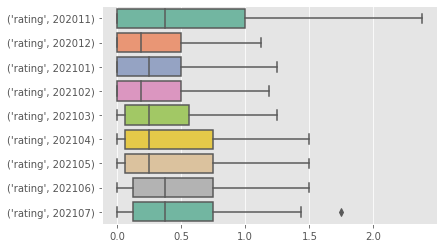

In [136]:
ax = sns.boxplot(data=pivot_bb_usage_info, orient="h", palette="Set2")
ax

<AxesSubplot:ylabel='Density'>

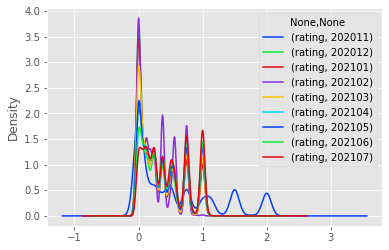

In [137]:
pivot_bb_usage_info.plot(kind = 'density')

<AxesSubplot:xlabel='None-None', ylabel='event_source.hash'>

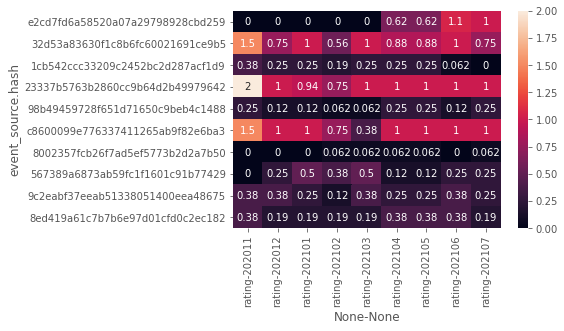

In [138]:
sns.heatmap(pivot_bb_usage_info.sample(n=10), annot=True)

In [139]:
pivot_bb_usage_info['Usage_Rating_Scaled'] = pivot_bb_usage_info.sum(axis=1)/len(year_month_list)
pivot_bb_usage_info

rating                                 \
                                 202011  202012  202101  202102 202103   
event_source.hash                                                        
59186358517212700922248718974976  2.000  0.7500  1.0000  0.7500  1.000   
00007cd39df96b9cf99fa19bca33862c  1.125  0.3750  0.5625  0.3750  0.750   
000084a38b0fa5ca77e7989aa5eb2d06  0.750  0.1875  0.1875  0.1875  0.125   
0000b72cb5dd05389b70e07ae2eaebd9  1.500  0.5000  0.5000  0.1875  0.375   
0000e468c37a20fddabc55cf098344ae  1.000  0.5000  0.5000  0.5000  0.500   
...                                 ...     ...     ...     ...    ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.000  0.0000  0.0000  0.0000  0.000   
fffdd1950a0cc6eb6e701bb732abadac  1.000  0.7500  0.7500  0.5000  0.750   
fffdede40561fb7b84c4c3941dec8e79  0.000  0.0000  0.0000  0.0000  0.000   
fffe637a366b3a25df9fbe75aea241b1  0.000  0.0000  0.0000  0.0000  0.000   
fffec93ce3fdf1421bce8728acdb866c  0.750  0.3750  0.3750  0.3750  0.375   

                                                                  \
                                  202104  202105  202106  202107   
event_source.hash                                                  
59186358517212700922248718974976  1.0000  1.0000  1.0000  1.0000   
00007cd39df96b9cf99fa19bca33862c  1.0000  1.0000  0.7500  0.5625   
000084a38b0fa5ca77e7989aa5eb2d06  0.3750  0.3750  0.3750  0.1250   
0000b72cb5dd05389b70e07ae2eaebd9  0.3750  0.3750  0.2500  0.2500   
0000e468c37a20fddabc55cf098344ae  0.7500  0.7500  1.0000  0.7500   
...                                  ...     ...     ...     ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.0000  0.0000  0.0000  0.3750   
fffdd1950a0cc6eb6e701bb732abadac  0.7500  0.7500  0.7500  0.6250   
fffdede40561fb7b84c4c3941dec8e79  0.1875  0.1875  0.5625  0.5625   
fffe637a366b3a25df9fbe75aea241b1  0.0000  0.0000  0.1250  0.1250   
fffec93ce3fdf1421bce8728acdb866c  0.3750  0.3750  0.3750  0.3750   

                                 Usage_Rating_Scaled  
                                                      
event_source.hash                                     
59186358517212700922248718974976            1.055556  
00007cd39df96b9cf99fa19bca33862c            0.722222  
000084a38b0fa5ca77e7989aa5eb2d06            0.298611  
0000b72cb5dd05389b70e07ae2eaebd9            0.479167  
0000e468c37a20fddabc55cf098344ae            0.694444  
...                                              ...  
fffc95756b7dccbd011d78c8a7d41e6b            0.041667  
fffdd1950a0cc6eb6e701bb732abadac            0.736111  
fffdede40561fb7b84c4c3941dec8e79            0.166667  
fffe637a366b3a25df9fbe75aea241b1            0.027778  
fffec93ce3fdf1421bce8728acdb866c            0.416667  

[67750 rows x 10 columns]

In [140]:
# labling usage bins
bins = [0, 0.33, 0.66,1]
labels = ['LOW','MEDIUM','HIGH']
pivot_bb_usage_info['Usage_Rating_Categorical'] = pd.cut(pivot_bb_usage_info['Usage_Rating_Scaled'], bins=bins, labels=labels)

rating                                 \
                                 202011  202012  202101  202102 202103   
event_source.hash                                                        
59186358517212700922248718974976  2.000  0.7500  1.0000  0.7500  1.000   
00007cd39df96b9cf99fa19bca33862c  1.125  0.3750  0.5625  0.3750  0.750   
000084a38b0fa5ca77e7989aa5eb2d06  0.750  0.1875  0.1875  0.1875  0.125   
0000b72cb5dd05389b70e07ae2eaebd9  1.500  0.5000  0.5000  0.1875  0.375   
0000e468c37a20fddabc55cf098344ae  1.000  0.5000  0.5000  0.5000  0.500   
...                                 ...     ...     ...     ...    ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.000  0.0000  0.0000  0.0000  0.000   
fffdd1950a0cc6eb6e701bb732abadac  1.000  0.7500  0.7500  0.5000  0.750   
fffdede40561fb7b84c4c3941dec8e79  0.000  0.0000  0.0000  0.0000  0.000   
fffe637a366b3a25df9fbe75aea241b1  0.000  0.0000  0.0000  0.0000  0.000   
fffec93ce3fdf1421bce8728acdb866c  0.750  0.3750  0.3750  0.3750  0.375   

                                                                  \
                                  202104  202105  202106  202107   
event_source.hash                                                  
59186358517212700922248718974976  1.0000  1.0000  1.0000  1.0000   
00007cd39df96b9cf99fa19bca33862c  1.0000  1.0000  0.7500  0.5625   
000084a38b0fa5ca77e7989aa5eb2d06  0.3750  0.3750  0.3750  0.1250   
0000b72cb5dd05389b70e07ae2eaebd9  0.3750  0.3750  0.2500  0.2500   
0000e468c37a20fddabc55cf098344ae  0.7500  0.7500  1.0000  0.7500   
...                                  ...     ...     ...     ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.0000  0.0000  0.0000  0.3750   
fffdd1950a0cc6eb6e701bb732abadac  0.7500  0.7500  0.7500  0.6250   
fffdede40561fb7b84c4c3941dec8e79  0.1875  0.1875  0.5625  0.5625   
fffe637a366b3a25df9fbe75aea241b1  0.0000  0.0000  0.1250  0.1250   
fffec93ce3fdf1421bce8728acdb866c  0.3750  0.3750  0.3750  0.3750   

                                 Usage_Rating_Scaled Usage_Rating_Categorical  
                                                                               
event_source.hash                                                              
59186358517212700922248718974976            1.055556                      NaN  
00007cd39df96b9cf99fa19bca33862c            0.722222                     HIGH  
000084a38b0fa5ca77e7989aa5eb2d06            0.298611                      LOW  
0000b72cb5dd05389b70e07ae2eaebd9            0.479167                   MEDIUM  
0000e468c37a20fddabc55cf098344ae            0.694444                     HIGH  
...                                              ...                      ...  
fffc95756b7dccbd011d78c8a7d41e6b            0.041667                      LOW  
fffdd1950a0cc6eb6e701bb732abadac            0.736111                     HIGH  
fffdede40561fb7b84c4c3941dec8e79            0.166667                      LOW  
fffe637a366b3a25df9fbe75aea241b1            0.027778                      LOW  
fffec93ce3fdf1421bce8728acdb866c            0.416667                   MEDIUM  

[67750 rows x 11 columns]

In [141]:
# adding category "NO" 
pivot_bb_usage_info['Usage_Rating_Categorical'] = pivot_bb_usage_info['Usage_Rating_Categorical'].cat.add_categories("NO")
pivot_bb_usage_info.loc[pivot_bb_usage_info['Usage_Rating_Scaled'] == 0.0, 'Usage_Rating_Categorical'] = "NO"
pivot_bb_usage_info = pivot_bb_usage_info[(pivot_bb_usage_info['Usage_Rating_Scaled'] != 0.0)]

In [142]:
pivot_bb_usage_info

rating                                 \
                                 202011  202012  202101  202102 202103   
event_source.hash                                                        
59186358517212700922248718974976  2.000  0.7500  1.0000  0.7500  1.000   
00007cd39df96b9cf99fa19bca33862c  1.125  0.3750  0.5625  0.3750  0.750   
000084a38b0fa5ca77e7989aa5eb2d06  0.750  0.1875  0.1875  0.1875  0.125   
0000b72cb5dd05389b70e07ae2eaebd9  1.500  0.5000  0.5000  0.1875  0.375   
0000e468c37a20fddabc55cf098344ae  1.000  0.5000  0.5000  0.5000  0.500   
...                                 ...     ...     ...     ...    ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.000  0.0000  0.0000  0.0000  0.000   
fffdd1950a0cc6eb6e701bb732abadac  1.000  0.7500  0.7500  0.5000  0.750   
fffdede40561fb7b84c4c3941dec8e79  0.000  0.0000  0.0000  0.0000  0.000   
fffe637a366b3a25df9fbe75aea241b1  0.000  0.0000  0.0000  0.0000  0.000   
fffec93ce3fdf1421bce8728acdb866c  0.750  0.3750  0.3750  0.3750  0.375   

                                                                  \
                                  202104  202105  202106  202107   
event_source.hash                                                  
59186358517212700922248718974976  1.0000  1.0000  1.0000  1.0000   
00007cd39df96b9cf99fa19bca33862c  1.0000  1.0000  0.7500  0.5625   
000084a38b0fa5ca77e7989aa5eb2d06  0.3750  0.3750  0.3750  0.1250   
0000b72cb5dd05389b70e07ae2eaebd9  0.3750  0.3750  0.2500  0.2500   
0000e468c37a20fddabc55cf098344ae  0.7500  0.7500  1.0000  0.7500   
...                                  ...     ...     ...     ...   
fffc95756b7dccbd011d78c8a7d41e6b  0.0000  0.0000  0.0000  0.3750   
fffdd1950a0cc6eb6e701bb732abadac  0.7500  0.7500  0.7500  0.6250   
fffdede40561fb7b84c4c3941dec8e79  0.1875  0.1875  0.5625  0.5625   
fffe637a366b3a25df9fbe75aea241b1  0.0000  0.0000  0.1250  0.1250   
fffec93ce3fdf1421bce8728acdb866c  0.3750  0.3750  0.3750  0.3750   

                                 Usage_Rating_Scaled Usage_Rating_Categorical  
                                                                               
event_source.hash                                                              
59186358517212700922248718974976            1.055556                      NaN  
00007cd39df96b9cf99fa19bca33862c            0.722222                     HIGH  
000084a38b0fa5ca77e7989aa5eb2d06            0.298611                      LOW  
0000b72cb5dd05389b70e07ae2eaebd9            0.479167                   MEDIUM  
0000e468c37a20fddabc55cf098344ae            0.694444                     HIGH  
...                                              ...                      ...  
fffc95756b7dccbd011d78c8a7d41e6b            0.041667                      LOW  
fffdd1950a0cc6eb6e701bb732abadac            0.736111                     HIGH  
fffdede40561fb7b84c4c3941dec8e79            0.166667                      LOW  
fffe637a366b3a25df9fbe75aea241b1            0.027778                      LOW  
fffec93ce3fdf1421bce8728acdb866c            0.416667                   MEDIUM  

[67720 rows x 11 columns]

In [143]:
pivot_bb_usage_info.to_csv("data/user_profile/BB_Usage_Categorical.csv")